In [50]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline
%config InlineBackend.figure_format = "retina"

all_data = pd.read_csv(r"D:\金属腐蚀\程序\选择模型\新数据集 23.08.04\Merged_file.csv")
#打乱顺序
all_data = all_data.sample(frac=1)

all_features = all_data.iloc[:,0:-2].values
all_labels = all_data.iloc[:,-1:]   #固定为一列

def maxminnorm(array):
    maxcols=array.max(axis=0)
    mincols=array.min(axis=0)
    data_shape = array.shape
    data_rows = data_shape[0]
    data_cols = data_shape[1]
    t=np.empty((data_rows,data_cols))
    for i in range(data_cols):
        t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])
    return t

all_features = maxminnorm(all_features)
all_features = np.nan_to_num(all_features)
all_labels = all_labels.values

d:\work apps\ENVS\ANACONDA\envs\d2l\lib\site-packages\IPython\core\interactiveshell.py:3135: DtypeWarning: Columns (550) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24844\804387625.py:34: RuntimeWarning: invalid value encountered in true_divide
  t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])


In [51]:
#特征选择
np.random.seed(1)
# 创建随机森林分类器
rfc1 = RandomForestClassifier(n_estimators=100, random_state=42)

# 训练随机森林分类器
rfc1.fit(all_features, all_labels)

# 输出特征重要性评估结果
importance = rfc1.feature_importances_

# 根据特征重要性评估结果筛选特征
selected_features1 = []
for i,v in enumerate(importance):
    if v > 0.0024:
        selected_features1.append(i)
#将选择出的特征，建立新的数据集select_features
select_features = all_features[:, selected_features1]
# Split data into train and test sets
#train_data, test_data, train_labels, test_labels = train_test_split(select_features, all_labels, test_size=0.15, random_state=42)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24844\2675639672.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc1.fit(all_features, all_labels)


In [52]:
select_features.shape[1]

151

In [53]:

train_score = []
test_score = []
precision = []    
recall = []
f1score = []
type0 = []
type1 = []
type2 = []
type3 = []
type4 = []

In [54]:
import numpy as np
import keras
from keras import layers

x_train, x_val, y_train, y_val = select_features[:2854],select_features[2854:],all_labels[:2854],all_labels[2854:]

# Define the model architecture
def make_model(input_shape, num_classes):
    initializer = "he_normal"
    
    input_layer = layers.Input(input_shape)
    
    conv1d = layers.Conv1D(filters=64, kernel_size=32, padding="same", activation="relu", kernel_initializer=initializer)(input_layer)
    conv1d = layers.BatchNormalization()(conv1d)
    conv1d = layers.MaxPooling1D(pool_size=2)(conv1d)
    
    conv1d = layers.Conv1D(filters=128, kernel_size=16, padding="same", activation="relu", kernel_initializer=initializer)(conv1d)
    conv1d = layers.BatchNormalization()(conv1d)
    conv1d = layers.MaxPooling1D(pool_size=2)(conv1d)
    
    conv1d = layers.Conv1D(filters=256, kernel_size=8, padding="same", activation="relu", kernel_initializer=initializer)(conv1d)
    conv1d = layers.BatchNormalization()(conv1d)
    conv1d = layers.MaxPooling1D(pool_size=2)(conv1d)
    
    conv1d = layers.Conv1D(filters=512, kernel_size=4, padding="same", activation="relu", kernel_initializer=initializer)(conv1d)
    conv1d = layers.BatchNormalization()(conv1d)
    conv1d = layers.MaxPooling1D(pool_size=2)(conv1d)
    
    conv1d = layers.Conv1D(filters=768, kernel_size=2, padding="same", activation="relu", kernel_initializer=initializer)(conv1d)
    conv1d = layers.BatchNormalization()(conv1d)
    conv1d = layers.MaxPooling1D(pool_size=2)(conv1d)
    
    flatten = layers.Flatten()(conv1d)
    
    dense = layers.Dense(512, activation="relu", kernel_initializer=initializer)(flatten)
    dense = layers.Dropout(0.5)(dense)
    
    dense = layers.Dense(256, activation="relu", kernel_initializer=initializer)(dense)
    dense = layers.Dropout(0.5)(dense)
    
    output_layer = layers.Dense(num_classes, activation="softmax")(dense)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Preprocess the labels into one-hot encoded vectors
num_classes = 5
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Set the input shape
input_shape = (select_features.shape[1], 1)

# Create the model
DNN = make_model(input_shape, num_classes)

# Compile the model
DNN.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
batch_size = 32
epochs = 10

DNN.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Evaluate the model
dnntrain_score = DNN.evaluate(x_train, y_train, verbose=0)
print("train accuracy:", dnntrain_score[1])
train_score.append(dnntrain_score[1])
dnntest_score = DNN.evaluate(x_val, y_val, verbose=0)
print("test accuracy:", dnntest_score[1])
test_score.append(dnntest_score[1])

y_pred = DNN.predict(x_val)
#将预测结果转换为类别标签
y_pred_labels = np.argmax(y_pred, axis=1)
# 将真实标签转换为类别标签（如果它们不是类别标签）
y_true_labels = np.argmax(y_val, axis=1)
# 使用真实标签和预测标签生成混淆矩阵
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
# 使用混淆矩阵计算分类报告
#report = classification_report(y_true_labels, y_pred_labels)
report_dict = classification_report(y_true_labels, y_pred_labels, output_dict=True)
# 打印分类报告
#print(report)


precision.append(report_dict['weighted avg']['precision'])
recall.append(report_dict['weighted avg']['recall'])
f1score.append(report_dict['weighted avg']['f1-score'])
type0.append(report_dict['0']['precision'])
type1.append(report_dict['1']['precision'])
type2.append(report_dict['2']['precision'])
type3.append(report_dict['3']['precision'])
type4.append(report_dict['4']['precision'])

Epoch 1/10
90/90 [==============================] - 13s 119ms/step - loss: 1.6173 - accuracy: 0.7015 - val_loss: 2.0966 - val_accuracy: 0.5189
Epoch 2/10
90/90 [==============================] - 11s 120ms/step - loss: 0.7536 - accuracy: 0.7898 - val_loss: 0.7485 - val_accuracy: 0.7251
Epoch 3/10
90/90 [==============================] - 11s 124ms/step - loss: 0.5775 - accuracy: 0.8269 - val_loss: 0.6922 - val_accuracy: 0.7924
Epoch 4/10
90/90 [==============================] - 11s 118ms/step - loss: 0.4798 - accuracy: 0.8448 - val_loss: 0.5419 - val_accuracy: 0.8121
Epoch 5/10
90/90 [==============================] - 10s 115ms/step - loss: 0.4320 - accuracy: 0.8609 - val_loss: 0.4386 - val_accuracy: 0.8583
Epoch 6/10
90/90 [==============================] - 10s 114ms/step - loss: 0.4402 - accuracy: 0.8605 - val_loss: 0.3218 - val_accuracy: 0.8864
Epoch 7/10
90/90 [==============================] - 11s 118ms/step - loss: 0.3699 - accuracy: 0.8812 - val_loss: 0.2549 - val_accuracy: 0.9004

In [55]:
report = classification_report(y_true_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       122
           1       1.00      0.56      0.72        16
           2       0.89      1.00      0.94        24
           3       0.95      0.83      0.88       290
           4       0.94      0.98      0.96       261

    accuracy                           0.91       713
   macro avg       0.91      0.87      0.87       713
weighted avg       0.91      0.91      0.91       713



In [56]:
train_data,test_data, train_labels, test_labels = select_features[:2854],select_features[2854:],all_labels[:2854],all_labels[2854:]

In [57]:
# CNN分类器
# Reshape data to fit CNN input shape
X_train = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
X_test = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))
input_shape = (len(select_features[0]), 1)
cnn_clf = Sequential()
cnn_clf.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
cnn_clf.add(MaxPooling1D(pool_size=2))
cnn_clf.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_clf.add(MaxPooling1D(pool_size=2))
cnn_clf.add(Flatten())
cnn_clf.add(Dense(128, activation='relu'))
cnn_clf.add(Dense(5, activation='softmax'))
cnn_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)
cnn_clf.fit(X_train, train_labels_one_hot, epochs=10)

#准确率
cnn_pred_train_onehot = cnn_clf.predict(X_train)
cnn_train_pred = [np.argmax(p) for p in cnn_pred_train_onehot]
cnn_train_acc = accuracy_score(train_labels, cnn_train_pred)
train_score.append(cnn_train_acc)
print('CNN train score',cnn_train_acc)
cnn_pred_one_hot = cnn_clf.predict(X_test)
cnn_pred = [np.argmax(p) for p in cnn_pred_one_hot]
cnn_test_acc = accuracy_score(test_labels, cnn_pred)
test_score.append(cnn_test_acc)
print('CNN test score',cnn_test_acc)

# 使用训练好的CNN模型对训练数据进行预测
cnn_pred_train_onehot = cnn_clf.predict(X_test)
# 将预测结果转换为类别标签
cnn_pred_train_labels = np.argmax(cnn_pred_train_onehot, axis=1)
# 将真实标签转换为类别标签（如果它们不是类别标签）
train_labels_labels = np.argmax(test_labels_one_hot, axis=1)
# 使用真实标签和预测标签生成混淆矩阵
conf_matrix = confusion_matrix(train_labels_labels, cnn_pred_train_labels)
# 使用混淆矩阵计算分类报告
report = classification_report(train_labels_labels, cnn_pred_train_labels)
# 打印分类报告
print(report)

report_dict = classification_report(train_labels_labels, cnn_pred_train_labels, output_dict=True)
precision.append(report_dict['weighted avg']['precision'])
recall.append(report_dict['weighted avg']['recall'])
f1score.append(report_dict['weighted avg']['f1-score'])
type0.append(report_dict['0']['precision'])
type1.append(report_dict['1']['precision'])
type2.append(report_dict['2']['precision'])
type3.append(report_dict['3']['precision'])
type4.append(report_dict['4']['precision'])

Epoch 1/10
90/90 [==============================] - 1s 6ms/step - loss: 0.8075 - accuracy: 0.6899
Epoch 2/10
90/90 [==============================] - 1s 6ms/step - loss: 0.4788 - accuracy: 0.8238
Epoch 3/10
90/90 [==============================] - 1s 7ms/step - loss: 0.4181 - accuracy: 0.8507
Epoch 4/10
90/90 [==============================] - 1s 6ms/step - loss: 0.3692 - accuracy: 0.8770
Epoch 5/10
90/90 [==============================] - 1s 6ms/step - loss: 0.3276 - accuracy: 0.8893
Epoch 6/10
90/90 [==============================] - 1s 7ms/step - loss: 0.3111 - accuracy: 0.8966
Epoch 7/10
90/90 [==============================] - 1s 6ms/step - loss: 0.2902 - accuracy: 0.9019
Epoch 8/10
90/90 [==============================] - 1s 6ms/step - loss: 0.2743 - accuracy: 0.9057
Epoch 9/10
90/90 [==============================] - 1s 6ms/step - loss: 0.2728 - accuracy: 0.9057
Epoch 10/10
90/90 [==============================] - 0s 2ms/step
CNN train score 0.9183601962158374
23/23 [===========

In [58]:

# 定义分类器并进行训练和预测
# MLP分类器
mlp_clf = MLPClassifier()
mlp_clf.fit(train_data, train_labels)
mlp_train_pred = mlp_clf.predict(train_data)
mlp_train_acc = accuracy_score(train_labels, mlp_train_pred)
train_score.append(mlp_train_acc)
print('mlp train acc',mlp_train_acc)
mlp_pred = mlp_clf.predict(test_data)
mlp_test_acc = accuracy_score(test_labels, mlp_pred)
test_score.append(mlp_test_acc)
print('mlp test acc',mlp_test_acc)

# 输出分类报告
report = classification_report(test_labels, mlp_pred)
# 打印分类报告
print(report)

report_dict = classification_report(test_labels, mlp_pred, output_dict=True)
precision.append(report_dict['weighted avg']['precision'])
recall.append(report_dict['weighted avg']['recall'])
f1score.append(report_dict['weighted avg']['f1-score'])
type0.append(report_dict['0']['precision'])
type1.append(report_dict['1']['precision'])
type2.append(report_dict['2']['precision'])
type3.append(report_dict['3']['precision'])
type4.append(report_dict['4']['precision'])

d:\work apps\ENVS\ANACONDA\envs\d2l\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mlp train acc 0.9260686755430974
mlp test acc 0.908835904628331
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       122
           1       0.86      0.75      0.80        16
           2       1.00      0.88      0.93        24
           3       0.92      0.86      0.89       290
           4       0.93      0.98      0.95       261

    accuracy                           0.91       713
   macro avg       0.91      0.87      0.89       713
weighted avg       0.91      0.91      0.91       713



In [59]:
# SVM分类器
svm_clf = SVC()
svm_clf.fit(train_data, train_labels)
svm_train_pred = svm_clf.predict(train_data)
svm_train_acc = accuracy_score(train_labels, svm_train_pred)
train_score.append(svm_train_acc)
svm_pred = svm_clf.predict(test_data)
svm_test_acc = accuracy_score(test_labels, svm_pred)
test_score.append(svm_test_acc)
print('svm train acc',svm_train_acc)
print('svm test acc',svm_test_acc)
# 输出分类报告
report = classification_report(test_labels, svm_pred)
# 打印分类报告
print(report)

report_dict = classification_report(test_labels, svm_pred, output_dict=True)
precision.append(report_dict['weighted avg']['precision'])
recall.append(report_dict['weighted avg']['recall'])
f1score.append(report_dict['weighted avg']['f1-score'])
type0.append(report_dict['0']['precision'])
type1.append(report_dict['1']['precision'])
type2.append(report_dict['2']['precision'])
type3.append(report_dict['3']['precision'])
type4.append(report_dict['4']['precision'])

# Decision Tree分类器
dt_clf = DecisionTreeClassifier()
dt_clf.fit(train_data, train_labels)
dt_train_pred = dt_clf.predict(train_data)
dt_train_acc = accuracy_score(train_labels, dt_train_pred)
train_score.append(dt_train_acc)
dt_pred = dt_clf.predict(test_data)
dt_test_acc = accuracy_score(test_labels, dt_pred)
test_score.append(dt_test_acc)
print('dt train acc',dt_train_acc)
print('dt test acc',dt_test_acc)
# 输出分类报告
report = classification_report(test_labels, dt_pred)
# 打印分类报告
print(report)

report_dict = classification_report(test_labels, dt_pred, output_dict=True)
precision.append(report_dict['weighted avg']['precision'])
recall.append(report_dict['weighted avg']['recall'])
f1score.append(report_dict['weighted avg']['f1-score'])
type0.append(report_dict['0']['precision'])
type1.append(report_dict['1']['precision'])
type2.append(report_dict['2']['precision'])
type3.append(report_dict['3']['precision'])
type4.append(report_dict['4']['precision'])

# Adaboost分类器
ab_clf = AdaBoostClassifier()
ab_clf.fit(train_data, train_labels)
ab_train_pred = ab_clf.predict(train_data)
ab_train_acc = accuracy_score(train_labels, ab_train_pred)
train_score.append(ab_train_acc)
ab_pred = ab_clf.predict(test_data)
ab_test_acc = accuracy_score(test_labels, ab_pred)
test_score.append(ab_test_acc)
print('ab train acc',ab_train_acc)
print('ab test acc',ab_test_acc)
# 输出分类报告
report = classification_report(test_labels, ab_pred)
# 打印分类报告
print(report)

report_dict = classification_report(test_labels, ab_pred, output_dict=True)
precision.append(report_dict['weighted avg']['precision'])
recall.append(report_dict['weighted avg']['recall'])
f1score.append(report_dict['weighted avg']['f1-score'])
type0.append(report_dict['0']['precision'])
type1.append(report_dict['1']['precision'])
type2.append(report_dict['2']['precision'])
type3.append(report_dict['3']['precision'])
type4.append(report_dict['4']['precision'])

# RandomForest分类器
rf_clf = RandomForestClassifier(n_estimators=150, random_state=1)
rf_clf.fit(train_data, train_labels)
rf_train_pred = rf_clf.predict(train_data)
rf_train_acc = accuracy_score(train_labels, rf_train_pred)
train_score.append(rf_train_acc)
rf_pred = rf_clf.predict(test_data)
rf_test_acc = accuracy_score(test_labels, rf_pred)
test_score.append(rf_test_acc)
print('rf train acc',rf_train_acc)
print('rf test acc',rf_test_acc)
# 输出分类报告
report = classification_report(test_labels, rf_pred)
# 打印分类报告
print(report)

report_dict = classification_report(test_labels, rf_pred, output_dict=True)
precision.append(report_dict['weighted avg']['precision'])
recall.append(report_dict['weighted avg']['recall'])
f1score.append(report_dict['weighted avg']['f1-score'])
type0.append(report_dict['0']['precision'])
type1.append(report_dict['1']['precision'])
type2.append(report_dict['2']['precision'])
type3.append(report_dict['3']['precision'])
type4.append(report_dict['4']['precision'])

d:\work apps\ENVS\ANACONDA\envs\d2l\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svm train acc 0.8906797477224947
svm test acc 0.8990182328190743
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       122
           1       0.80      0.75      0.77        16
           2       0.95      0.88      0.91        24
           3       0.92      0.85      0.88       290
           4       0.92      0.98      0.95       261

    accuracy                           0.90       713
   macro avg       0.88      0.87      0.87       713
weighted avg       0.90      0.90      0.90       713

dt train acc 1.0
dt test acc 0.938288920056101
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       122
           1       0.79      0.94      0.86        16
           2       1.00      0.79      0.88        24
           3       0.94      0.93      0.94       290
           4       0.95      0.96      0.95       261

    accuracy                           0.94       713
   macro avg       

d:\work apps\ENVS\ANACONDA\envs\d2l\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ab train acc 0.7312543798177996
ab test acc 0.7194950911640954
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       122
           1       0.67      0.12      0.21        16
           2       1.00      0.50      0.67        24
           3       0.82      0.50      0.62       290
           4       0.63      0.91      0.74       261

    accuracy                           0.72       713
   macro avg       0.78      0.60      0.62       713
weighted avg       0.75      0.72      0.70       713



C:\Users\Administrator\AppData\Local\Temp\ipykernel_24844\4224510338.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(train_data, train_labels)


rf train acc 1.0
rf test acc 0.9663394109396914
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       122
           1       0.93      0.88      0.90        16
           2       1.00      0.96      0.98        24
           3       0.97      0.97      0.97       290
           4       0.98      0.97      0.97       261

    accuracy                           0.97       713
   macro avg       0.96      0.95      0.96       713
weighted avg       0.97      0.97      0.97       713



随机森林的AUC-ROC曲线

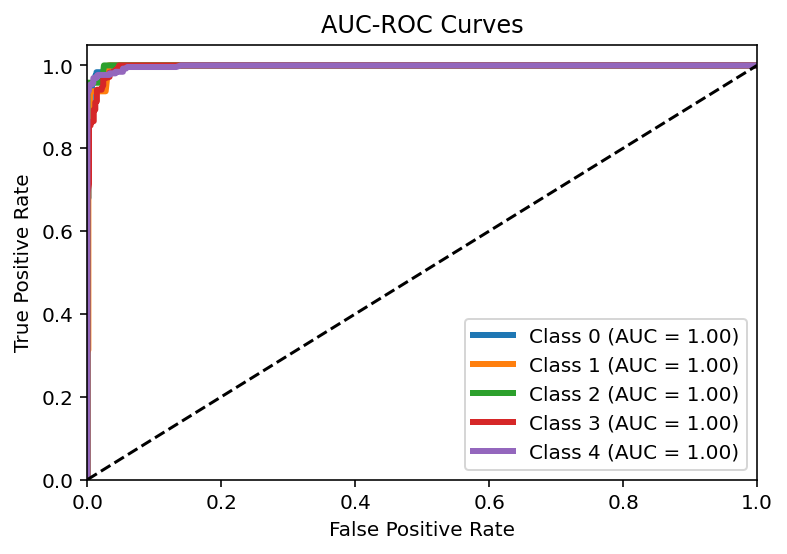

In [60]:
#随机森林的AUC-ROC曲线
from sklearn.metrics import roc_curve, auc

# Get the probability predictions for each class
proba_predictions = rf_clf.predict_proba(test_data)

# Compute the AUC-ROC curve for each class
#plt.figure(figsize=(10, 8))

for class_index in range(num_classes):
    # Convert the class labels to binary encoding
    binary_labels = (test_labels == class_index).astype(int)
    
    # Get the predicted probabilities for the positive class
    positive_probs = proba_predictions[:, class_index]
    
    # Compute the FPR, TPR, and AUC for the current class
    fpr, tpr, _ = roc_curve(binary_labels, positive_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot the AUC-ROC curve for the current class
    plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (class_index, roc_auc),linewidth = 3)

# Set the plot properties and legend
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves')
plt.legend(loc='lower right')

# Show the plot
plt.show()

随机森林预测结果的混淆矩阵

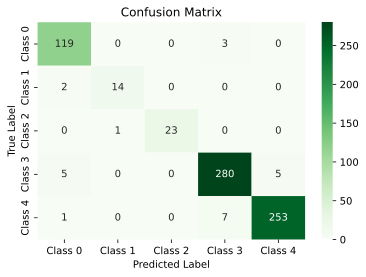

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "svg"

# 预测验证数据集的类别
pred_labels = rf_pred

# 计算混淆矩阵
cm = confusion_matrix(test_labels, pred_labels)

# 获取类别标签
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# 绘制混淆矩阵的热力图
plt.figure()#figsize=(12, 9)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

In [62]:
import matplotlib.pyplot as plt
title = ['DNN','CNN','MLP','SVM','Decision Tree','Adaboost','Random Forest']
import csv
with open("all_contrast_result.csv","w") as file:
    writer = csv.writer(file)
    #writer.writerow(title)
    rows = zip(title,train_score,test_score)
    writer.writerows(rows)


*准确率*

In [63]:
print(precision)
print(recall)
print(f1score)
print(test_score)

[0.913407103374309, 0.9187967654910151, 0.9101357776660407, 0.9003582495470153, 0.9394206081804812, 0.7499036638894867, 0.966606107192666]
[0.906030855539972, 0.9186535764375876, 0.908835904628331, 0.8990182328190743, 0.938288920056101, 0.7194950911640954, 0.9663394109396914]
[0.905018958909031, 0.9185462847011131, 0.9083812997900338, 0.8984700333179376, 0.9382514102071422, 0.7025860308688702, 0.9663588276551003]
[0.9060308337211609, 0.9186535764375876, 0.908835904628331, 0.8990182328190743, 0.938288920056101, 0.7194950911640954, 0.9663394109396914]


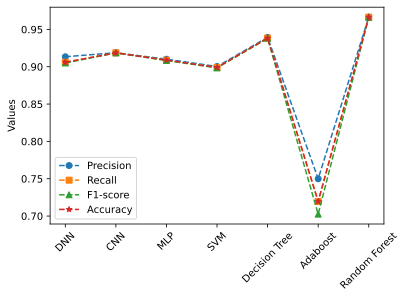

<Figure size 600x400 with 0 Axes>

In [64]:
plt.close()

%matplotlib inline
%config InlineBackend.figure_format = "svg"

# 模拟数据
x_values = [1, 2, 3, 4, 5,6,7]
y1_values = precision
y2_values = recall
y3_values = f1score
y4_values = test_score

# 绘制折线图，并显示每个数据点的形状
plt.plot(x_values, y1_values, label='Precision', marker='o', linestyle='--')
plt.plot(x_values, y2_values, label='Recall', marker='s', linestyle='--')
plt.plot(x_values, y3_values, label='F1-score', marker='^', linestyle='--')
plt.plot(x_values, y4_values, label='Accuracy', marker='*', linestyle='--')

# 添加图例
plt.legend()

# 设置X轴坐标点的名称
plt.xticks(x_values, title, rotation=45)

# 添加标题和标签
#plt.title('The results of each algorithm model')
#plt.xlabel('X-axis Label')
plt.ylabel('Values')
plt.figure(dpi=100)
# 显示图形
plt.show()
#plt.savefig('D:\金属腐蚀\个人总结\论文\新数据集结果图片\七类算法四种指标对比折线图.jpg', dpi=300)
#plt.close()

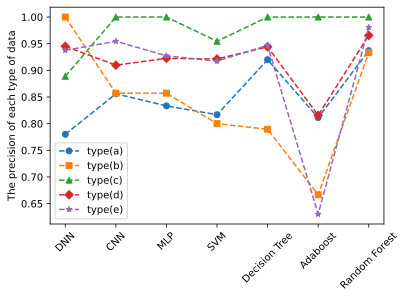

In [65]:

y1_values = type0
y2_values = type1
y3_values = type2
y4_values = type3
y5_values = type4

# 绘制折线图，并显示每个数据点的形状
plt.plot(x_values, y1_values, label='type(a)', marker='o', linestyle='--')
plt.plot(x_values, y2_values, label='type(b)', marker='s', linestyle='--')
plt.plot(x_values, y3_values, label='type(c)', marker='^', linestyle='--')
plt.plot(x_values, y4_values, label='type(d)', marker='D', linestyle='--')
plt.plot(x_values, y5_values, label='type(e)', marker='*', linestyle='--')

# 添加图例
plt.legend()

# 设置X轴坐标点的名称
plt.xticks(x_values, title, rotation=45)

# 添加标题和标签
#plt.title('Robustness comparison of algorithm models')
#plt.xlabel('X-axis Label')
plt.ylabel('The precision of each type of data')

# 显示图形
plt.show()

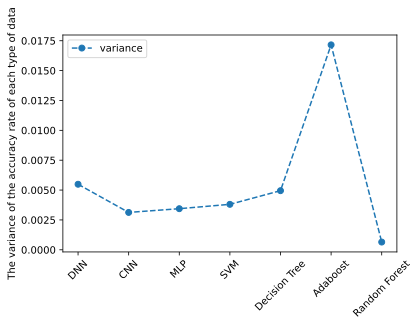

In [66]:
# 计算方差
def varcompute(num):
    data_num = []
    data_num.append(type0[num])
    data_num.append(type1[num])
    data_num.append(type2[num])
    data_num.append(type3[num])
    data_num.append(type4[num])
    variance = np.var(data_num)
    return variance

all_variance = []
for i in range(len(title)):
    all_variance.append(varcompute(i))

# 绘制折线图，并显示每个数据点的形状
plt.plot(x_values, all_variance, label='variance', marker='o', linestyle='--')

# 添加图例
plt.legend()

# 设置X轴坐标点的名称
plt.xticks(x_values, title, rotation=45)

# 添加标题和标签
#plt.title('Robustness comparison of algorithm models')
#plt.xlabel('X-axis Label')
plt.ylabel('The variance of the accuracy rate of each type of data')

# 显示图形
plt.show()

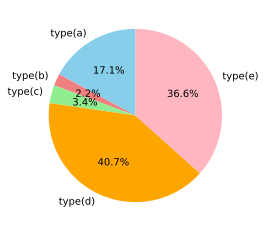

In [67]:
def typenum(label,type):
    num = 0
    for i in label:
        if i == type:
            num += 1
    return num

all_num = []
for i in range(5):
    all_num.append(typenum(test_labels,i))

# 模拟数据
pielabels = ['type(a)', 'type(b)', 'type(c)', 'type(d)', 'type(e)']
sizes = all_num  # 每部分的占比

# 绘制饼状图
plt.pie(sizes, labels=pielabels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'lightpink'])

# 添加标题
#plt.title('Pie Chart with Percentages')

# 显示图形
plt.show()

In [30]:
print(precision)
print(recall)
print(f1score)
print(test_score)
print(type0)
print(type1)
print(type2)
print(type3)
print(type4)

[0.9149206769166296, 0.9018883314554654, 0.9171219431661803, 0.8904638806707156, 0.9133398484489071, 0.6990029520119426, 0.9552843889653517]
[0.9116409537166901, 0.9018232819074333, 0.9144460028050491, 0.8906030855539971, 0.9130434782608695, 0.5848527349228612, 0.9551192145862553]
[0.9120865400072908, 0.9013829777141613, 0.9142578497610431, 0.8900413921215132, 0.9130588655359113, 0.5960517818669732, 0.9551387430934133]
[0.9116409420967102, 0.9018232819074333, 0.9144460028050491, 0.8906030855539971, 0.9130434782608695, 0.5848527349228612, 0.9551192145862553]
[0.8380952380952381, 0.8469387755102041, 0.8598130841121495, 0.8404255319148937, 0.9292929292929293, 0.3129496402877698, 0.9693877551020408]
[0.6666666666666666, 0.8, 0.7647058823529411, 0.6875, 0.8461538461538461, 0.7058823529411765, 0.9285714285714286]
[1.0, 1.0, 1.0, 1.0, 0.8235294117647058, 0.52, 0.9375]
[0.916955017301038, 0.9125874125874126, 0.948339483394834, 0.8839590443686007, 0.9016393442622951, 0.75, 0.9438943894389439]
[

In [68]:
import csv
csv_file_path = r"D:\金属腐蚀\个人总结\论文\最终图片\最终结果\result1.csv"
# 打开CSV文件进行写入
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # 写入标题行，如果有需要的话
    csv_writer.writerow(title) 
    csv_writer.writerow(precision)
    csv_writer.writerow(recall)
    csv_writer.writerow(f1score)
    csv_writer.writerow(test_score)

    csv_writer.writerow(type0)
    csv_writer.writerow(type1)
    csv_writer.writerow(type2)
    csv_writer.writerow(type3)   
    csv_writer.writerow(type4) 

print(f"Results have been written to {csv_file_path}")

Results have been written to D:\金属腐蚀\个人总结\论文\最终图片\最终结果\result1.csv
